In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

"""
ICP Reference : https://github.com/ClayFlannigan/icp/blob/master/icp.py
"""

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

def icp(A, B, init_pose=None, max_iterations=100, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T[:m, :])
    dst[:m,:] = np.copy(B.T[:m, :])

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)   # indices = dst의 index [1,3,0,2]
                                                                     #           src의 index [0,1,2,3]

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)

        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A[:, :m], src[:m,:].T)

    return T

def v2t(pose):
    # from vector to transform
    tx = pose[0]
    ty = pose[1]
    theta = pose[2]
    transform = np.array([[np.cos(theta), -np.sin(theta), tx],
                          [np.sin(theta), np.cos(theta), ty],
                          [0, 0, 1]])

    return transform

def t2v(T):
    # from transform to vector
    v = np.zeros((3,))
    v[:2] = T[:2,2]
    v[2] = np.arctan2(T[1,0], T[0,0])
    return 

1


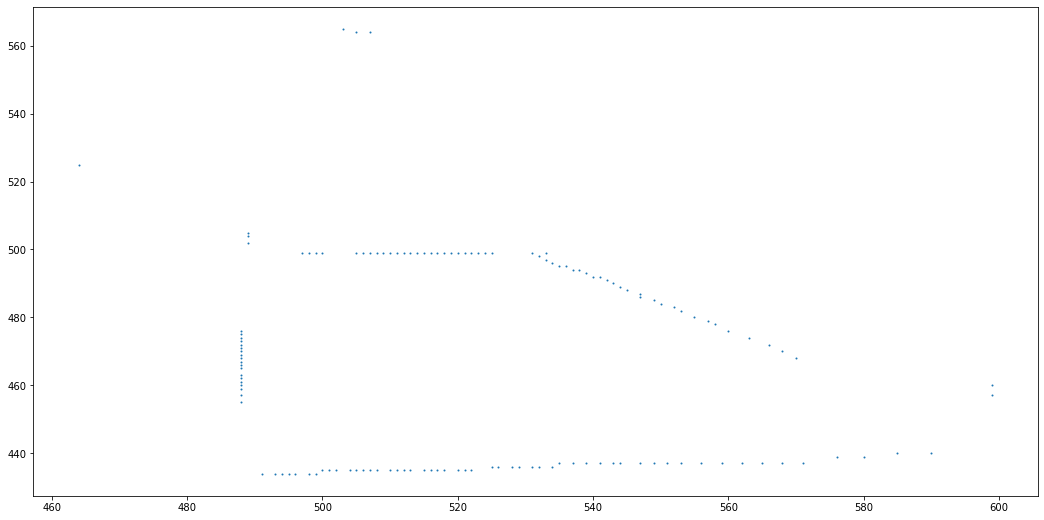

In [50]:
fig = plt.figure(figsize=(18,9))

map_data_x = []
map_data_y = []
pose = [0,0,0]

for i in range(1,2):
    print(i)
    x = np.load(f'points{i}.npy')

    if i == 1:
        map_data_x += x[:, 1].tolist()
        map_data_y += x[:, 0].tolist()
        continue
        
    #print(np.vstack((map_data_x, map_data_y)))
    T = icp(x, np.vstack((map_data_x, map_data_y)))
    
    points_h = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    result = np.dot(points_h, T.T)
        
    map_data_x += result[:, 1].tolist()
    map_data_y += result[:, 0].tolist()

plt.scatter(map_data_x, map_data_y, s=1)

plt.show()